In [ ]:
import pandas as pd 
from IPython.display import JSON
import ipywidgets as widgets
#import google_auth_oauthlib.flow # use this to work on authentification
import googleapiclient.discovery
import googleapiclient.errors
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bagta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bagta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
from dotenv import load_dotenv
import os

# Charger les variables d'environnement depuis le fichier .env
load_dotenv()

# Accéder à la clé API
api_key = os.getenv("YOUTUBE_API_KEY")

# print("Clé API chargée :", api_key)

In [75]:
# channels id 
## to find the id of a channel : right click on the ytb channel home page, 
# view source code, search for "https://www.youtube.com/channel/" in the page

# UCWedHS9qKebauVIK2J7383g : underscore 
# UCWnfDPdZw6A23UtuBpYBbAg : dr nozman
channel_ids = ["UCWedHS9qKebauVIK2J7383g",
               # add more channels here
               ]

api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=api_key)

In [21]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [23]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Underscore_,743000,99508754,248,UUWedHS9qKebauVIK2J7383g


In [34]:
def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [36]:
playlist_id = "UUWedHS9qKebauVIK2J7383g"
video_ids = get_video_ids(youtube, playlist_id)
print(len(video_ids))

249


In [38]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [39]:
video_df = get_video_details(youtube, video_ids)
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,dGR5w14FsVo,Underscore_,Comment Nintendo terrorise les hackers,Pour essayer les VPS d'Infomaniak : https://bi...,None,2024-11-14T17:15:04Z,453350,12044,None,630,PT36M58S,hd,false
1,KQrxq4QSXhg,Underscore_,Le problème fondamental du nouveau mode Vocal ...,Pour en savoir plus sur les nouvelles puces d'...,None,2024-11-06T17:15:00Z,288788,9427,None,478,PT23M58S,hd,false
2,Uh-4KO33y6c,Underscore_,Comment Minecraft a révolutionné la génération...,Pour essayer Odoo facturation : https://www.od...,None,2024-11-04T19:08:47Z,176641,6607,None,210,PT24M27S,hd,false
3,Nj4uLGRmuok,Underscore_,La stratégie perturbante des lunettes de Meta,Pour découvrir les offres VPS d'Hostinger : ht...,None,2024-10-29T18:13:10Z,369790,9921,None,593,PT21M,hd,false
4,5Iuog2JtXDI,Underscore_,Créer des jeux vidéo n'a jamais été aussi simple,Découvrir l'app Odoo Projets : https://www.odo...,None,2024-09-30T16:45:00Z,227357,7979,None,413,PT25M45S,hd,false


In [41]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [42]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df.head()

Could not get comments for video WN1e1tyn7q8
Could not get comments for video uZeMc8Mtszo


,video_id,comments
0,dGR5w14FsVo,[⚠ Nous recherchons des profils bien spécifiqu...
1,KQrxq4QSXhg,[⚠ Nous recherchons des profils bien spécifiqu...
2,Uh-4KO33y6c,[on entend vraiment rtx voice/broadcast .\nl'a...
3,Nj4uLGRmuok,"[Bravo pour cet interview, l'invité est calme ..."
4,5Iuog2JtXDI,[Bonjour à toutes et tous !\nPour compléter la...


## Data préprocessing

In [43]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [44]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)

In [45]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [ ]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
# video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

# converting to timedelta
video_df['durationSecs'] = pd.to_timedelta(video_df['durationSecs'])

# converting to secondes
video_df['durationSecs'] = video_df['durationSecs'].dt.total_seconds()

video_df['durationSecs']

0      2218.0
1      1438.0
2      1467.0
3      1260.0
4      1545.0
        ...  
244     958.0
245     816.0
246    1794.0
247    2211.0
248     890.0
Name: durationSecs, Length: 249, dtype: float64

In [47]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df[['tagsCount']]

,tagsCount
0,0
1,0
2,0
3,0
4,0
...,...
244,7
245,6
246,0
247,0


In [52]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount
0,dGR5w14FsVo,Underscore_,Comment Nintendo terrorise les hackers,Pour essayer les VPS d'Infomaniak : https://bi...,None,2024-11-14 17:15:04+00:00,453350.0,12044.0,NaN,630.0,PT36M58S,hd,false,Thursday,2218.0,0
1,KQrxq4QSXhg,Underscore_,Le problème fondamental du nouveau mode Vocal ...,Pour en savoir plus sur les nouvelles puces d'...,None,2024-11-06 17:15:00+00:00,288788.0,9427.0,NaN,478.0,PT23M58S,hd,false,Wednesday,1438.0,0
2,Uh-4KO33y6c,Underscore_,Comment Minecraft a révolutionné la génération...,Pour essayer Odoo facturation : https://www.od...,None,2024-11-04 19:08:47+00:00,176641.0,6607.0,NaN,210.0,PT24M27S,hd,false,Monday,1467.0,0
3,Nj4uLGRmuok,Underscore_,La stratégie perturbante des lunettes de Meta,Pour découvrir les offres VPS d'Hostinger : ht...,None,2024-10-29 18:13:10+00:00,369790.0,9921.0,NaN,593.0,PT21M,hd,false,Tuesday,1260.0,0
4,5Iuog2JtXDI,Underscore_,Créer des jeux vidéo n'a jamais été aussi simple,Découvrir l'app Odoo Projets : https://www.odo...,None,2024-09-30 16:45:00+00:00,227357.0,7979.0,NaN,413.0,PT25M45S,hd,false,Monday,1545.0,0


## Data analysis - EDA

### Best performing videos

C:\Users\bagta\AppData\Local\Temp\ipykernel_3068\1065382101.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


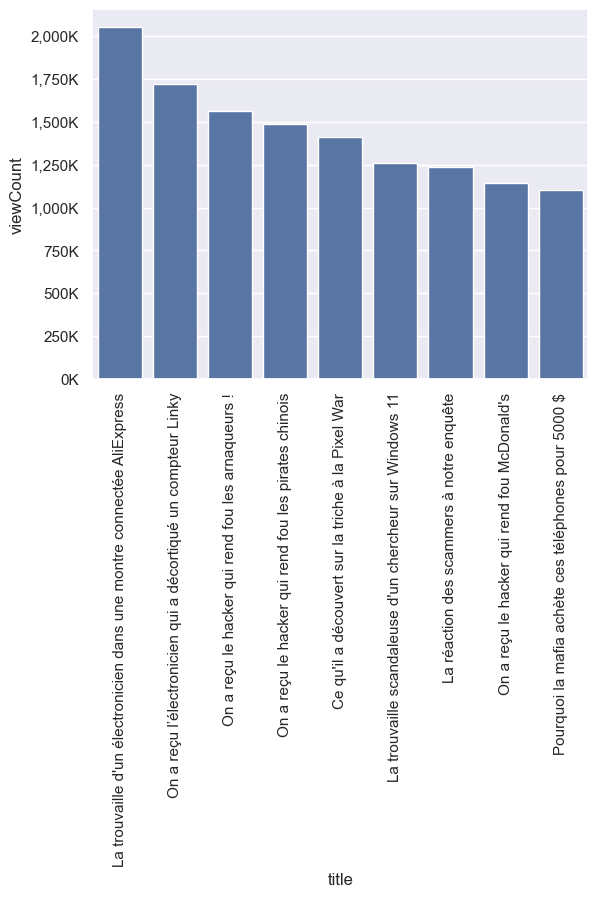

In [54]:
ax = sns.barplot(x= 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst performing videos

C:\Users\bagta\AppData\Local\Temp\ipykernel_3068\2210929034.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


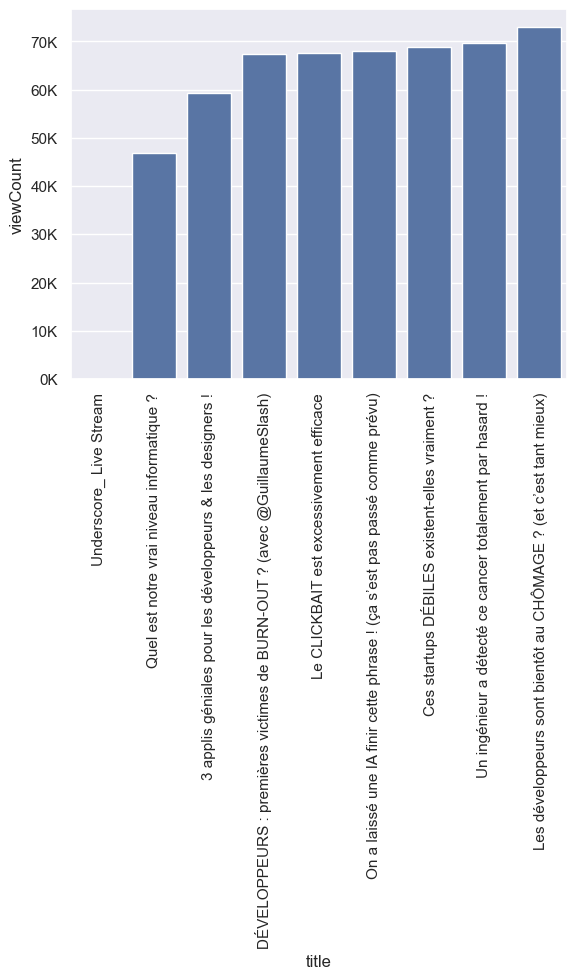

In [55]:
ax = sns.barplot(x= 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video

C:\Users\bagta\AppData\Local\Temp\ipykernel_3068\296268482.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'], palette = 'pastel')


<Axes: xlabel='channelTitle', ylabel='viewCount'>

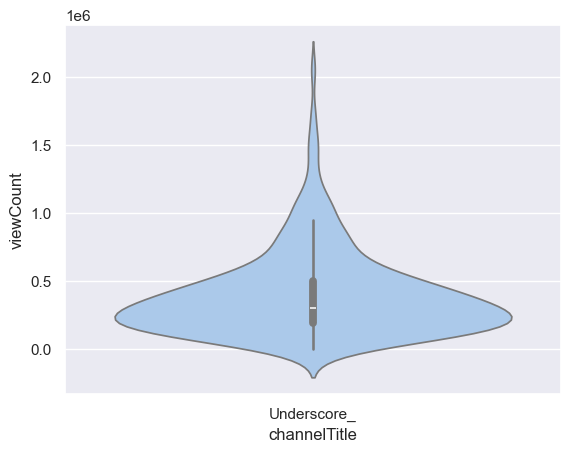

In [56]:
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'], palette = 'pastel')

### Views vs. likes and comments 

<Axes: xlabel='likeCount', ylabel='viewCount'>

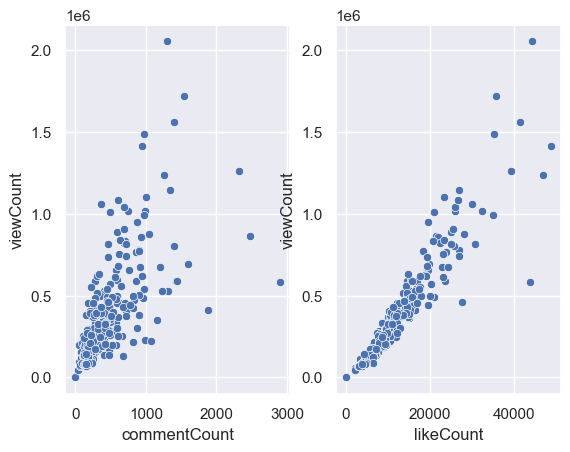

In [57]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Videos duration

<Axes: xlabel='durationSecs', ylabel='Count'>

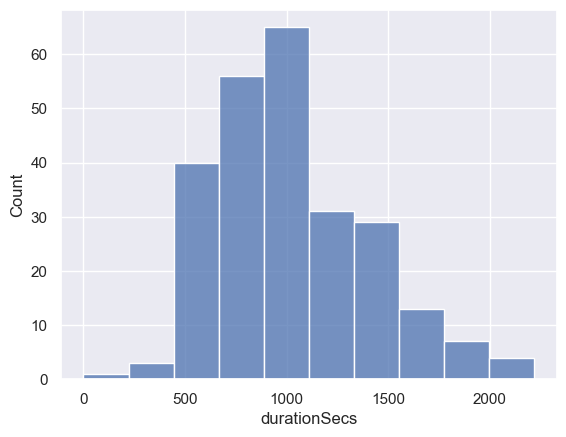

In [58]:
sns.histplot(data = video_df, x = 'durationSecs', bins=10)

In [61]:
from statistics import median
float_list = video_df['durationSecs'].tolist()
median(float_list)

965.0

### Wordcloud for words in title

In [65]:
stop_words_list = stopwords.words('french')
stop_words_list.extend(['La', 'Il', 'Le', 'Cette', 'elle', 'va', 'Ce', 'un', 'ça', 'être', 'cette', 'plus','il','est','avec','Ce','n', 'et','dont','s', 'Les', 'pas'])
type(stop_words_list)

list

In [66]:
stop_words = set(stop_words_list)
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 


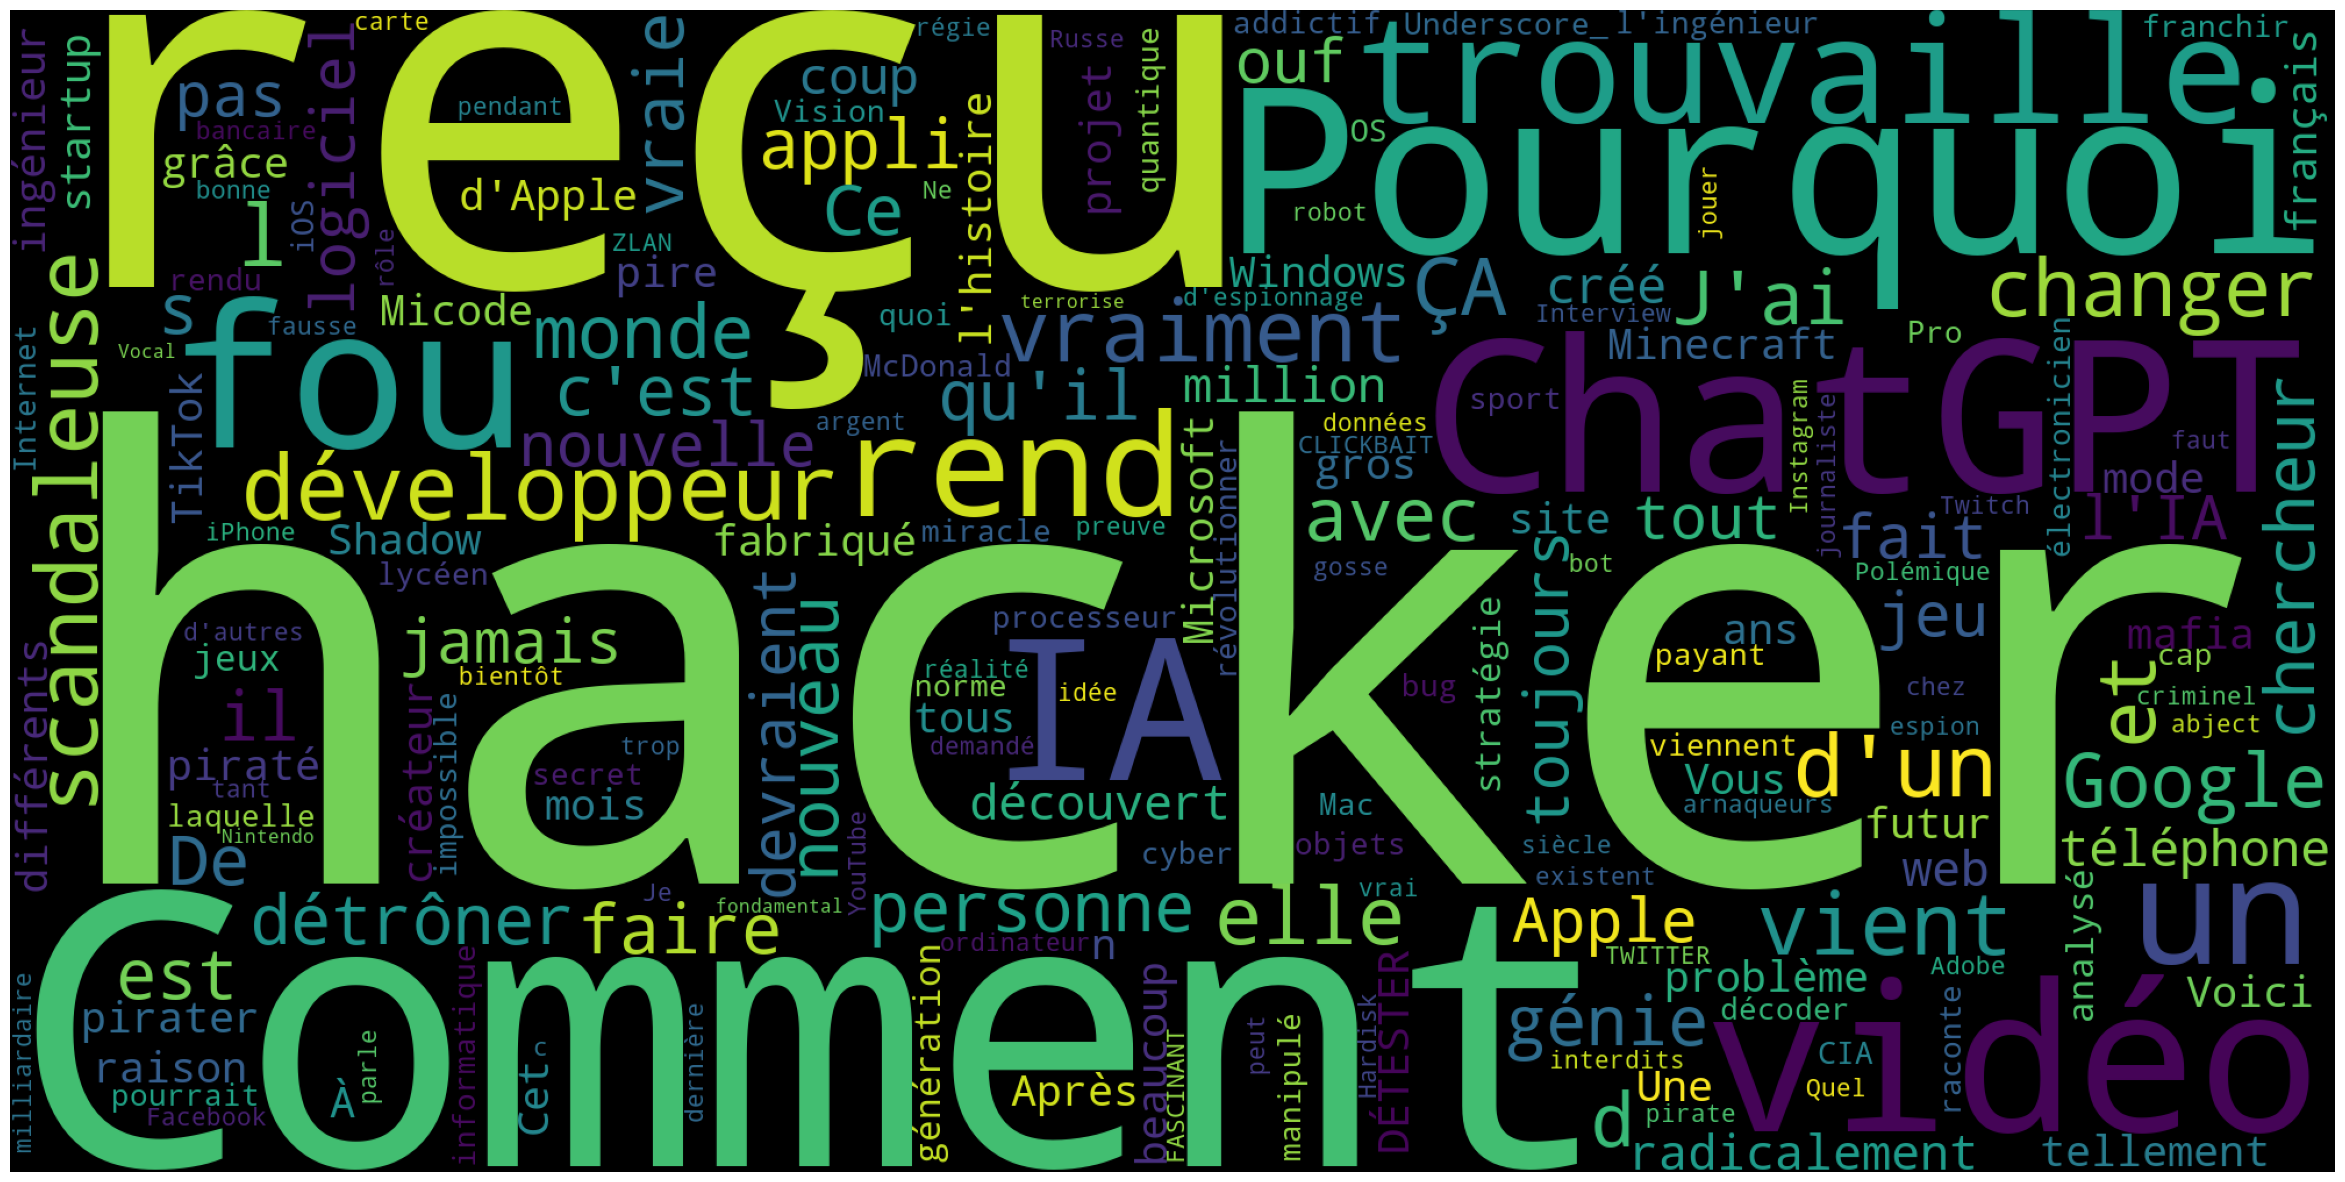

In [67]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Upload schedule

In [70]:
video_df.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption', 'pushblishDayName',
       'durationSecs', 'tagsCount', 'title_no_stopwords'],
      dtype='object')

In [ ]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
day_df

,count
pushblishDayName,
Monday,63
Tuesday,30
Wednesday,46
Thursday,56
Friday,20
Saturday,3
Sunday,31


In [72]:
day_df = day_df.reset_index()

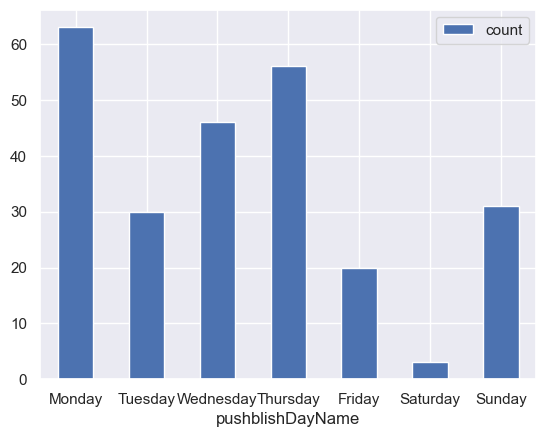

In [73]:
ax = day_df.plot.bar(x='pushblishDayName', y ='count', rot=0)